In [8]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass


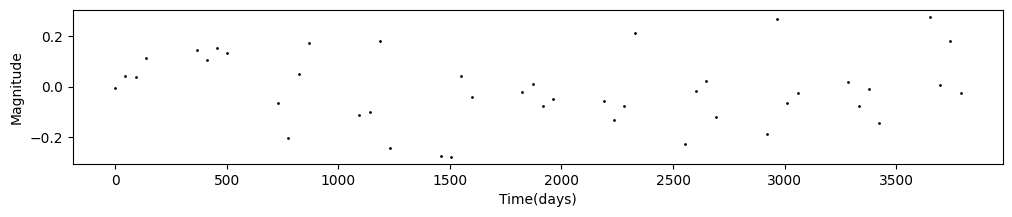

In [34]:
@dataclass(frozen=True)
class SurveyParams:
    observation_period: float
    cadence: float
    cadence_deviation: float
    photometric_error: float
    gap_period: float
LSST = SurveyParams(observation_period = 10 * 365, cadence = 7, cadence_deviation = 1, photometric_error = 0.01, gap_period = 182)
CRTS = SurveyParams(observation_period = 11 * 365, cadence = 46, cadence_deviation = 3, photometric_error = 0.1, gap_period = 200)
ILMT = SurveyParams(observation_period = 7 * 365, cadence = 7, cadence_deviation = 3, photometric_error = 0.1, gap_period = 182) 
AXIS = SurveyParams(observation_period = 7 * 365, cadence = 7, cadence_deviation = 3, photometric_error = 0.1, gap_period = 182)


def generate_damped_RW(tau, sigma, survey):
    
    baseline= survey.observation_period
    t = np.arange(0, baseline, 1)

    # Generate the PSD for the DRW
    frequencies = np.fft.fftfreq(len(t), t[1] - t[0])
    fft_numerator = 4*tau 
    fft_denominator = 1 + (2 * np.pi * frequencies * tau) ** 2
    psd = sigma ** 2 * fft_numerator / fft_denominator

    #DRW in Frequency domain
    fft_drw = np.sqrt(psd) * np.random.randn(len(t)) / np.sqrt(len(t))

    # Convert back to time domain
    drw = np.fft.ifft(fft_drw) * len(t)

    # Add random Gaussian errors
    errors = np.random.normal(0, survey.photometric_error, len(t))
    drw_with_errors = drw + errors
    cadence_with_dev = np.random.normal(0, survey.cadence_deviation, 1)
    #return drw_with_errors
    tele_time = np.array([])
    tele_drw = np.array([])
    gap_start = 0
    while gap_start < baseline:
        gap_end = gap_start + 365 - survey.gap_period
        
        tele_time = np.concatenate((tele_time, 
                                t[gap_start:gap_end:survey.cadence]))
        tele_drw = np.concatenate((tele_drw,
                               drw_with_errors[gap_start:gap_end:survey.cadence]))
        gap_start = gap_end + survey.gap_period

    cadence_with_dev = np.random.normal(survey.cadence, survey.cadence_deviation, 1)
    for i in tele_time:
        i = i+ cadence_with_dev
        
    
    fig,ax = plt.subplots()
    scat = ax.scatter(tele_time, tele_drw, color = "black", s=1)

    ax.set_xlabel('Time(days)')
    ax.set_ylabel('Magnitude')
    fig.set_figwidth(12)
    fig.set_figheight(2)
    plt.show


generate_damped_RW(10, 0.1, CRTS)


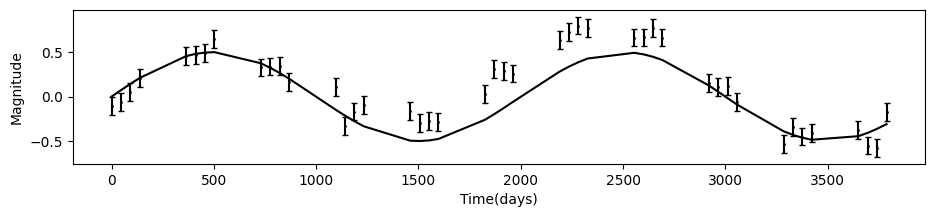

In [35]:
def generate_drw_with_sinusoid(tau, sigma, survey, period, amplitude):
    baseline= survey.observation_period
    t = np.arange(0, baseline, 1)
    # Generate the PSD for the DRW
    frequencies = np.fft.fftfreq(len(t), t[1] - t[0])
    fft_numerator = 4*tau 
    fft_denominator = 1 + (2 * np.pi * frequencies * tau) ** 2
    psd = sigma ** 2 * fft_numerator / fft_denominator

    #DRW in Frequency domain
    fft_drw = np.sqrt(psd) * np.random.randn(len(t)) / np.sqrt(len(t))

    # Convert back to time domain
    drw = np.fft.ifft(fft_drw) * len(t)

    # Add random Gaussian errors
    errors = np.random.normal(0, survey.photometric_error, len(t))
    drw_with_errors = drw + errors

    #return drw_with_errors
    tele_time = np.array([])
    tele_drw = np.array([])
    gap_start = 0
    while gap_start < baseline:
        gap_end = gap_start + 365 - survey.gap_period
        tele_time = np.concatenate((tele_time, 
                                t[gap_start:gap_end:survey.cadence]))
        tele_drw = np.concatenate((tele_drw,
                               drw_with_errors[gap_start:gap_end:survey.cadence]))
        gap_start = gap_end + survey.gap_period
    
    cadence_with_dev = np.random.normal(survey.cadence, survey.cadence_deviation, 1)
    for i in tele_time:
        i = i+ cadence_with_dev
    sinusoid = amplitude * np.sin(2 * np.pi * (tele_time - tele_time[0]) / period)


    # Add the sinusoidal signal to the DRW light curve
    lsst_drw_sine = tele_drw + sinusoid
    yerr = np.full_like(lsst_drw_sine, survey.photometric_error)

    fig1,bx = plt.subplots()
    drw_errorbar = bx.errorbar(tele_time, lsst_drw_sine, yerr=yerr, fmt='o', color="black",ecolor="black", capsize=2, label="DRW with errors", markersize = 1)
    # Plot the smooth sinusoidal curve
    sin_plot = bx.plot(tele_time, sinusoid, color='black', label="Sinusoidal signal")

    bx.set_xlabel('Time(days)')
    bx.set_ylabel('Magnitude')
    fig1.set_figwidth(11)
    fig1.set_figheight(2)
    plt.show

generate_drw_with_sinusoid(1000,0.1, CRTS, 2000,0.5)
